## 06-1 신경망 알고리즘을 벡터화하자

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
# 데이터 세트를 훈련, 검증, 테스트 세트로 나누기

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

In [4]:
# 시작하기 전에 사용할 데이터의 크기를 확인하는 것은 좋은 습관이다 !

print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [5]:
class SingleLayer:

    def __init__ (self, learning_rate = 0.1, l1 = 0, l2 = 0):
        self.w = None  # 가중치
        self.b = None  # 절편
        self.losses = []  # 훈련 손실
        self.val_losses = []  # 검증 손실
        self.w_history = []  # 가중치 기록
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b
        return z

    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m  # 가중치에 대한 그래디언트를 계산
        b_grad = np.sum(err) / m
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None)  # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a

    def reg_loss(self):
        # 가중치에 규제를 적용
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w ** 2)

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)  # 정방향 계산
        a = self.activation(z)  # 활성화 함수
        a = np.clip(a, 1e-10, 1-1e-10)  # 출력 값을 클리핑
        # 로그 손실과 규제 손실을 더해서 리스트에 추가
        val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교해서 True의 비율을 반환
        return np.mean(self.predict(x) == y.reshape(-1, 1))

    def predict(self, x):
        z = self.forpass(x)
        return z > 0

    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        y = y.reshape(-1, 1)  # 타깃을 열 벡터로 바꾼다
        y_val = y_val.reshape(-1, 1)
        m = len(x)  # 샘플 개수 저장
        self.w = np.ones((x.shape[1], 1))  # 가중치를 초기화
        self.b = 0  # 절편을 초기화
        self.w_history.append(self.w.copy())  # 가중치를 기록
        # epochs 만큼 반복
        for i in range(epochs):
            z = self.forpass(x)  # 정방향 계산
            a = self.activation(z)  # 활성화 함수 적용
            err = -(y - a)
            # 오차를 역전파하여 그래디언트를 계산
            w_grad, b_grad = self.backprop(x, err)
            # 그래디언트에 페널티 항의 미분 값을 더합니다.
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            # 그래디언트에 페널티 항의 미문 값을 더한다
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            # 가중치를 기록한다
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑하기
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산
            self.update_val_loss(x_val, y_val)

In [6]:
# 안정적인 학습을 위해 사이킷런의 StandardScaler 클래스로 전처리하자
from sklearn.preprocessing import StandardScaler

In [7]:
# **************** 이건 내가 해본 거 그냥

print((x.shape[1], 1))

(30, 1)


In [8]:
# 훈련 데이터 표준화 전처리하기

scaler = StandardScaler()  # 객체 선언
scaler.fit(x_train)  # fit( ) 메서드로 변환 규칙을 익히고
x_train_scaled = scaler.transform(x_train)  # 훈련 세트에 표준화 적용
x_val_scaled = scaler.transform(x_val)  # 검증 세트에 표준화 적용

In [9]:
# 이 데이터를 SingleLayer 클래스 객체에 전달해서 배치 경사 하강법 적용해 보자

single_layer = SingleLayer(l2 = 0.01)
single_layer.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs = 10000)
single_layer.score(x_val_scaled, y_val)

# 에포크 횟수를 늘린 이유는 확률적 경사 하강법과 경사 하강법은 에포크마다 가중치 업데이트를 하는 횟수에 차이가 있기 때문
# score 메서드로 출력된 검증 세트의 점수는 5장과 동일하지만 손실 함수 값의 변화는 다르다.
# 훈련 손실과 검증 손실을 그래프로 출력해 보자

0.978021978021978

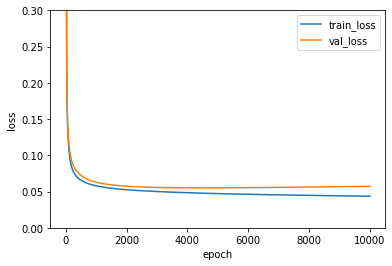

In [10]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# 5장에서 봤던 그래프에 비해 손실값이 비교적 안정적으로 감소하는 것을 알 수 있다
# 왜 이런 결과가 나오는지 가중치의 변화 그래프를 살펴보자

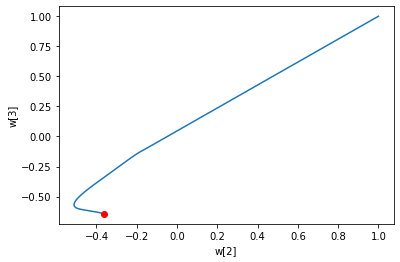

In [11]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

# 가중치의 변화가 연속적이므로 손실값도 안정적으로 수렴된다.
# 하지만 배치 경사 하강법은 매번 전체 훈련 데이터를 사용하기 때문에 연산 비용이 많이 들고 최솟값에 수렴하는 시간도 많이 걸린다.

## 06-2 2개의 층을 연결합니다

In [27]:
class DualLayer(SingleLayer):
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.activation(z1)            # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)               # 은닉층의 크기
        self.w2 = np.ones((self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)          # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)
        m = len(x)                    # 샘플 개수를 저장합니다.
        self.init_weights(x.shape[1]) # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            a = self.training(x, y, m)
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    def training(self, x, y, m):
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.activation(z)    # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에 페널티 항의 미분 값을 더합니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [28]:
# 모델 훈련하기

dual_layer = DualLayer(l2 = 0.01)
dual_layer.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs = 20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

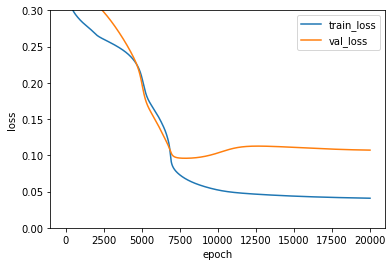

In [32]:
# 훈련 손실과 검증 손실 그래프 분석하기

plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()